In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


# model selection 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, merge
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


In [8]:
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import  Image
from keras.applications.vgg16 import VGG16

In [1]:
import zipfile
import urllib.request

In [2]:
# Download MOvielens data
print('Downloading movielens data..')
data = urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", 'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip', 'r')
zip_ref.extractall()
print('DOne. Dataset contains:')
print(zip_ref.read('ml-100k/u.info').decode("utf-8"))


DOne. Dataset contains:
943 users
1682 items
100000 ratings



In [5]:
!cat ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [4]:
!head ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [9]:
# import Users movielen data

users_cols = ['user_id', 'age', 'sex', "occupation", 'zip_code']

users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, 
                    encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# we have 3 tables of data
# users, movies, and ratings review


In [12]:
# import ratings
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols,
                      encoding='latin-1')

In [13]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
ratings.shape

(100000, 4)

In [15]:
# movies information table
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

In [16]:
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols,
                     encoding="latin-1")
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# Create a new column for the release year of movies
movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

#Make sure the rating is in float
ratings['rating'] = ratings['rating'].apply(lambda x:float(x))

#Since the ids start at 1, we shift them to start at 0

users['user_id'] = users['user_id'].apply(lambda x: x-1)
movies['movie_id'] = movies['movie_id'].apply(lambda x: x-1)
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: x-1)
ratings['user_id'] = ratings['user_id'].apply(lambda x: x-1)


In [18]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    '''Create two new columns 'genre' and 'all_genres' in the dataset movies
        - all_genres: all the active genres of the movie.
        - genre: randomly sampled from the active genres.
    '''
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        return '-'.join(active)
    movies['genre'] = [get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [19]:
movies[['movie_id', 'title', 'genre', 'all_genres']].head()

,movie_id,title,genre,all_genres
0,0,Toy Story (1995),Animation,Animation-Children-Comedy
1,1,GoldenEye (1995),Action,Action-Adventure-Thriller
2,2,Four Rooms (1995),Thriller,Thriller
3,3,Get Shorty (1995),Action,Action-Comedy-Drama
4,4,Copycat (1995),Crime,Crime-Drama-Thriller


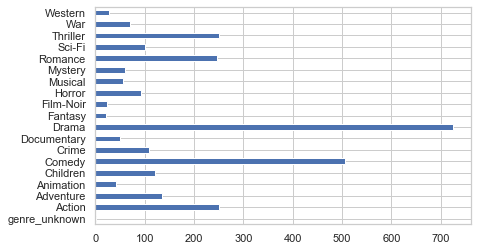

In [20]:
movies[genre_cols].sum().plot(kind='barh')

In [21]:
users.describe(include=[np.object])

,sex,occupation,zip_code
count,943,943,943
unique,2,21,795
top,M,student,55414
freq,670,196,9


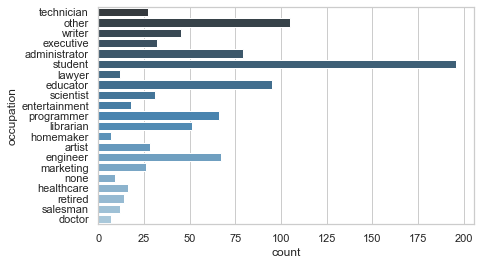

In [23]:
sns.countplot(y='occupation', data=users, palette='Blues_d')

In [25]:
#Base on the ratings dataset, group the data by user-id
# then apply aggregate operations 'count' and mean on rating

users_ratings = ratings.groupby('user_id', as_index=False).agg({'rating':
                                                                ['count', 'mean']})

#Set the column names 'user_id', rating_count, rating_mean to user_ratings dataset

users_ratings.columns = ['user_id', 'rating_count', 'rating_mean']

# Merge users_ratings with users dataset on user_id

users_ratings = users_ratings.merge(users, on='user_id')

users_ratings.head()

,user_id,rating_count,rating_mean,age,sex,occupation,zip_code
0,0,272,3.610294,24,M,technician,85711
1,1,62,3.709677,53,F,other,94043
2,2,54,2.796296,23,M,writer,32067
3,3,24,4.333333,24,M,technician,43537
4,4,175,2.874286,33,F,other,15213


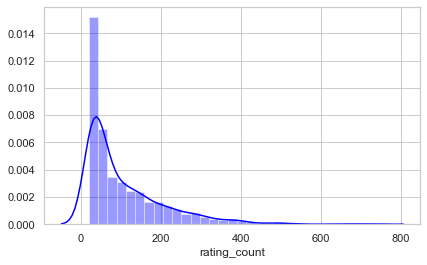

In [26]:
sns.distplot(users_ratings['rating_count'], color='blue')


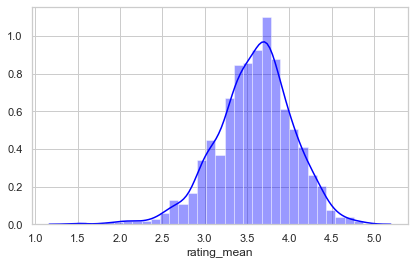

In [27]:
sns.distplot(users_ratings['rating_mean'], color='blue')

In [28]:
# Group movies by movie_id, and calculate mean and count

movies_ratings = ratings.groupby('movie_id', as_index=False).agg({'rating':
                                                                  ['count', 'mean']})
movies_ratings.columns = ['movie_id', 'rating_count', 'rating_mean']

#Merge movies_ratings with movie on  movie_id

movies_ratings = movies_ratings.merge(movies, on='movie_id')

movies_ratings.head()

,movie_id,rating_count,rating_mean,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,452,3.878319,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,...,0,0,0,0,0,0,0,1995,Animation,Animation-Children-Comedy
1,1,131,3.206107,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,...,0,0,0,0,1,0,0,1995,Action,Action-Adventure-Thriller
2,2,90,3.033333,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,209,3.550239,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,...,0,0,0,0,0,0,0,1995,Action,Action-Comedy-Drama
4,4,86,3.302326,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,...,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller


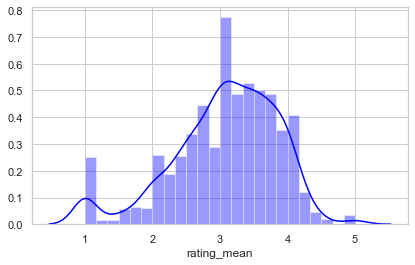

In [29]:
sns.distplot(movies_ratings['rating_mean'], color='blue')


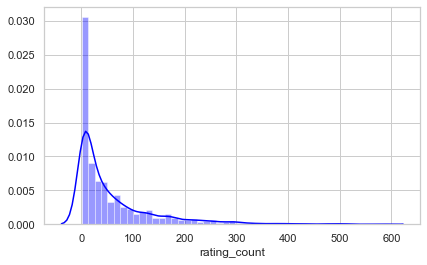

In [30]:
sns.distplot(movies_ratings['rating_count'], color='blue')

In [31]:
movies_ratings[['movie_id', 'title', 'rating_count', 'rating_mean']].sort_values('rating_count',
                                                                                 ascending=False).head(10)

,movie_id,title,rating_count,rating_mean
49,49,Star Wars (1977),583,4.358491
257,257,Contact (1997),509,3.803536
99,99,Fargo (1996),508,4.155512
180,180,Return of the Jedi (1983),507,4.007890
293,293,Liar Liar (1997),485,3.156701
285,285,"English Patient, The (1996)",481,3.656965
287,287,Scream (1996),478,3.441423
0,0,Toy Story (1995),452,3.878319
299,299,Air Force One (1997),431,3.631090
120,120,Independence Day (ID4) (1996),429,3.438228


In [32]:
# List 10 movies with rating_count > 20, and sorted by rating mean descending

(movies_ratings[['movie_id', 'title', 
                 'rating_count', 'rating_mean']][movies_ratings['rating_count'] > 20].sort_values('rating_mean', ascending=False).head(10))

,movie_id,title,rating_count,rating_mean
407,407,"Close Shave, A (1995)",112,4.491071
317,317,Schindler's List (1993),298,4.466443
168,168,"Wrong Trousers, The (1993)",118,4.466102
482,482,Casablanca (1942),243,4.456790
113,113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761
63,63,"Shawshank Redemption, The (1994)",283,4.445230
602,602,Rear Window (1954),209,4.387560
11,11,"Usual Suspects, The (1995)",267,4.385768
49,49,Star Wars (1977),583,4.358491
177,177,12 Angry Men (1957),125,4.344000


In [3]:
import os
os.getcwd()

'C:\\Users\\HT\\Desktop\\Coderschool\\Mydoing\\Data Science Project'

In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'Costa Rican Household Poverty Level Prediction.ipynb',
 'Data Scientist Tutorial.ipynb',
 'Dataset',
 'Explanation of Embedding Layer.ipynb',
 'Home Credit Default Risk.ipynb',
 'House Prices Predict.ipynb',
 'Recommendation System.ipynb',
 'Text data.ipynb',
 'Toxic Comment Classification Challenge.ipynb',
 'Twitter Sentiment Analysis.ipynb']

In [5]:
train = pd.read_csv('Dataset/movielen/ratings.csv')
train.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
train['userId'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [8]:
train['movieId'].unique()

array([  31, 1029, 1061, ...,  129, 4736, 6425], dtype=int64)

In [9]:
train['userId'].isnull().sum()

0

In [10]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
train['rating'].min()

0.5

In [12]:
train['rating'].max()

5.0

In [15]:
train['userId'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [16]:
train['userId'] = train['userId'].astype('category').cat.codes.values
train['userId']

0           0
1           0
2           0
3           0
4           0
         ... 
99999     670
100000    670
100001    670
100002    670
100003    670
Name: userId, Length: 100004, dtype: int16

In [17]:
train['movieId'] = train['movieId'].astype('category').cat.codes.values

In [18]:
train['userId'].value_counts(ascending=True)

0        20
208      20
248      20
324      20
437      20
       ... 
72     1610
14     1700
623    1735
563    1868
546    2391
Name: userId, Length: 671, dtype: int64